In [1]:
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import pickle

In [2]:
# load the data
data_file = open('images_zero_one.txt', 'rb')
train_data, train_labels, test_data, test_labels = pickle.load(data_file, encoding='latin1')
data_file.close()

train_data = np.reshape(train_data, [-1, 28, 28])
test_data = np.reshape(test_data, [-1, 28, 28])
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

train_data = (train_data - np.mean(train_data)) / np.std(train_data)
test_data = (test_data - np.mean(test_data)) / np.std(test_data)

In [3]:
hm_train, dim1, dim2 = train_data.shape
hm_test = len(test_labels)
hm_classes = 2
batch_size = 2
max_epoch = 1
eval_interval = 20
learning_rate = 0.002
test_acc = np.zeros((0, 1))
train_acc = np.zeros((0, 1))
train_loss = np.zeros((0, 1))

In [4]:
def weight_init(shape):
    #initial = tf.truncated_normal(shape, mean=0.1, stddev=0.01) / 100
    initial = tf.ones(shape) / 100
    return tf.Variable(initial)

def bias_init(shape):
    initial = tf.constant(0.001, shape=shape)
    return tf.Variable(initial)

def conv2d(x, w):
    hm_data, dim1, dim2 = x.get_shape().as_list()
    #print(hm_data, dim1, dim2)
    stride = 1
    filter_size1, filter_size2 = w.get_shape().as_list()
    #print(filter_size1, filter_size2)
    #convoled_im = tf.Variable(tf.ones([int(hm_data), int((dim1 - filter_size1) / stride + 1), int((dim2 - filter_size2) / stride + 1)]))
    convoled_im = tf.zeros([0, 24, 24])
    for im in np.arange(int(hm_data)): 
        slices = tf.zeros([0, 24])
        for i in np.arange(int((dim1 - filter_size1) / stride + 1)):
            row = tf.zeros([1, 0])
            for j in np.arange(int((dim2 - filter_size2) / stride + 1)):
                reception_area = x[im, i:i+filter_size1, j:j+filter_size2]
                #print(reception_area.get_shape().as_list())
                temp = tf.reshape(tf.reduce_sum(tf.reshape(reception_area, [filter_size1, filter_size2]) * w), [1, 1])
                row = tf.concat([row, temp], 1)
                #print(temp.get_shape().as_list())
                #convoled_im[im, i, j].assign(temp)
            slices = tf.concat([slices, row], 0)
        convoled_im = tf.concat([convoled_im, slices[None, :, :]], 0)
    return tf.reshape(convoled_im, [-1, 24, 24])

def avg_pool(x):
    hm_data, dim1, dim2 = x.get_shape().as_list()
    print(hm_data, dim1, dim2)
    stride = 2
    kernel_size = 2
    #pooled_im = tf.Variable(tf.zeros([int(hm_data), (dim1 - kernel_size) / stride + 1, (dim2 - kernel_size) / stride + 1]), trainable=False)
    pooled_im = tf.zeros([0, 12, 12])
    for im in np.arange(hm_data):
        slices = tf.zeros([0, 12])
        for i in np.arange(int((dim1 - kernel_size) / stride + 1)):
            row = tf.zeros([1, 0])
            for j in np.arange(int((dim2 - kernel_size) / stride + 1)):
                reception_area = x[im, i * stride:i * stride + kernel_size, j * stride:j * stride+kernel_size]
                temp = tf.reshape(tf.reduce_mean(reception_area), [1, 1])
                row = tf.concat([row, temp], 1)
                
            slices = tf.concat([slices, row], 0)
        pooled_im = tf.concat([pooled_im, slices[None, :, :]], 0)
            
    return pooled_im

def sigmoid_cross_entropy(y_out, y):
    return tf.matmul(-tf.transpose(y), tf.log(tf.sigmoid(y_out))) - tf.matmul(tf.transpose(1-y), tf.log(1 - tf.sigmoid(y_out)))

def compute_gradient(fc, y_out, w_fc, b_fc, x, y, h_conv1, h_conv2):
    grad_w_fc = tf.matmul(tf.transpose(fc), (1 - tf.sigmoid(y_out)) * -y) - tf.matmul(tf.transpose(fc), (1-y) * tf.sigmoid(y_out))
    grad_b_fc = tf.reshape(tf.reduce_sum((1 - tf.sigmoid(y_out)) * -y - (1-y) * tf.sigmoid(y_out)), [1, 1])
    grad_fc = tf.matmul(-y * (1 - tf.sigmoid(y_out)), tf.transpose(w_fc)) - tf.matmul((1-y) * tf.sigmoid(y_out), tf.transpose(w_fc))
    #print(grad_fc.get_shape().as_list())
    #activation1 = tf.zeros([0, 24, 24])
    #activation2 = tf.zeros([0, 24, 24])
    grad_w1 = tf.zeros([5, 5])
    grad_w2 = tf.zeros([5, 5])
    grad_b1 = tf.zeros([24, 24])
    grad_b2 = tf.zeros([24, 24])
    for im in np.arange(batch_size):
        one_im = tf.reshape(grad_fc[im, :], [288, 1])
        # print(one_im.get_shape().as_list())
        pool1 = tf.reshape(one_im[0:144, 0], [12, 12])
        pool2 = tf.reshape(one_im[144:, 0], [12, 12])
        act1 = tf.zeros([0, 24])
        act2 = tf.zeros([0, 24])
        for i in np.arange(12):
            act_r1 = tf.zeros([2, 0])
            act_r2 = tf.zeros([2, 0])
            for j in np.arange(12):
                temp1 = tf.ones([2, 2]) * pool1[i, j] / 4
                temp2 = tf.ones([2, 2]) * pool2[i, j] / 4
                act_r1 = tf.concat([act_r1, temp1], 1)
                act_r2 = tf.concat([act_r2, temp2], 1)
                
            act1 = tf.concat([act1, act_r1], 0)
            act2 = tf.concat([act2, act_r2], 0)
            
        #activation1 = tf.concat([activation1, act1[None, :, :]], 0)
        #activation2 = tf.concat([activation2, act2[None, :, :]], 0)
        print(grad_b1.get_shape().as_list())
        grad_C1 = tf.cast(h_conv1[im, :, :] > 0, tf.float32) * act1[None, :, :]
        grad_C2 = tf.cast(h_conv2[im, :, :] > 0, tf.float32) * act2[None, :, :]
        grad_b1 += tf.reshape(grad_C1, [24, 24])
        grad_b2 += tf.reshape(grad_C2, [24, 24])
        print(grad_C1.get_shape().as_list())
        print(grad_b1.get_shape().as_list())
        f1 = tf.zeros([0, 5])
        f2 = tf.zeros([0, 5])
        for r in np.arange(5):
            t1 = tf.zeros([1, 0])
            t2 = tf.zeros([1, 0])
            for c in np.arange(5):
                t1 = tf.concat([t1, tf.reshape(tf.reduce_sum(x[im, r:r+24, c:c+24] * grad_C1), [1, 1])], 1)
                t2 = tf.concat([t2, tf.reshape(tf.reduce_sum(x[im, r:r+24, c:c+24] * grad_C2), [1, 1])], 1)
            
            f1 = tf.concat([f1, t1], 0)
            f2 = tf.concat([f2, t2], 0)
            
        grad_w1 += f1
        grad_w2 += f2
        
    return grad_w_fc, grad_b_fc, grad_w1, grad_b1, grad_w2, grad_b2

def train_opt(grad_w_fc, grad_b_fc, grad_w1, grad_b1, grad_w2, grad_b2, w_fc, b_fc, w1, b1, w2, b2, rate):
    tf.assign_add(w_fc, -rate * grad_w_fc)
    print(b1.get_shape().as_list())
    print(grad_b1.get_shape().as_list())
    
    tf.assign_add(b_fc, -rate * grad_b_fc[:, 0])
    tf.assign_add(w1, -rate * grad_w1)
    tf.assign_add(b1, -rate * grad_b1)
    tf.assign_add(w2, -rate * grad_w2)
    tf.assign_add(b2, -rate * grad_b2)
    
    return w_fc, b_fc, w1, b1, w2, b2

In [5]:
# define the flow
x = tf.placeholder(dtype=tf.float32, shape=[batch_size, 28, 28])
y = tf.placeholder(dtype=tf.float32, shape=[batch_size, 1])

w1 = weight_init([5, 5])
b1 = bias_init([24, 24])

w2 = weight_init([5, 5])
b2 = bias_init([24, 24])

In [6]:
# Convolutional layer, and pooling with two filters
h_conv1 = tf.nn.relu(conv2d(x, w1) + b1)
h_pool1 = avg_pool(h_conv1)

h_conv2 = tf.nn.relu(conv2d(x, w2) + b2)
h_pool2 = avg_pool(h_conv2)

# fully connected layer
fc = tf.concat([tf.reshape(h_pool1, [-1, 144]), tf.reshape(h_pool2, [-1, 144])], 1)
w_fc = weight_init([144 * 2, 1])
b_fc = bias_init([1])

# output layer
y_out = tf.matmul(fc, w_fc) + b_fc
# y_pred = tf.sigmoid(y_out)

2 24 24
2 24 24


In [7]:
y_pred = tf.sigmoid(y_out)

In [8]:
# The backward propagation
# define the loss function
# cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_out, labels=y))
cross_entropy = sigmoid_cross_entropy(y_out, y)
G_w_fc, G_b_fc, G_w1, G_b1, G_w2, G_b2 = compute_gradient(fc, y_out, w_fc, b_fc, x, y, h_conv1, h_conv2)

[24, 24]
[1, 24, 24]
[24, 24]
[24, 24]
[1, 24, 24]
[24, 24]


In [9]:
#a = train_opt(G_w_fc, G_b_fc, G_w1, G_b1, G_w2, G_b2, w_fc, b_fc, w1, b1, w2, b2, learning_rate)
b = tf.train.AdamOptimizer(learning_rate=0.002).minimize(cross_entropy)
#c = tf.train.RMSPropOptimizer(learning_rate=0.008, decay=0.6).minimize(cross_entropy)

correct_prediction = tf.equal(tf.to_float(y_pred >= 0.5), y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
for epoch in np.arange(max_epoch):
    #re_order = np.random.permutation(hm_train)
    re_order = np.arange(hm_train)
        
    for i in np.arange(600): #(int(hm_train / batch_size)):
        batch_x = train_data[re_order[i * batch_size:(i + 1) * batch_size], :, :]
        batch_y = train_labels[re_order[i * batch_size:(i + 1) * batch_size]][:, None]
            
        ce = sess.run(cross_entropy, feed_dict={x: batch_x, y: batch_y})
        train_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        #test_accuracy = sess.run(accuracy, feed_dict={x: test_data, y: test_labels[:, None]})
        train_acc = np.vstack((train_acc, train_accuracy))
        train_loss = np.vstack((train_loss, ce))
        #test_acc = np.vstack((test_acc, test_accuracy))
            
        if i % eval_interval == 0:
            #learning_rate *= 0.85
            print("epoch: %d step: %d, training accuracy: %g, loss: %g" %
                            (epoch, i, np.mean(train_acc), np.mean(train_loss)))
                
        
        #sess.run(a, feed_dict={x: batch_x, y:batch_y})
        sess.run(b, feed_dict={x: batch_x, y:batch_y})
        

epoch: 0 step: 0, training accuracy: 1, loss: 1.24421
epoch: 0 step: 20, training accuracy: 0.738095, loss: 1.38729
epoch: 0 step: 40, training accuracy: 0.865854, loss: 1.05594
epoch: 0 step: 60, training accuracy: 0.909836, loss: 0.749008
epoch: 0 step: 80, training accuracy: 0.932099, loss: 0.578084
epoch: 0 step: 100, training accuracy: 0.940594, loss: 0.505785
epoch: 0 step: 120, training accuracy: 0.946281, loss: 0.435683
epoch: 0 step: 140, training accuracy: 0.953901, loss: 0.37574
epoch: 0 step: 160, training accuracy: 0.959627, loss: 0.330045
epoch: 0 step: 180, training accuracy: 0.964088, loss: 0.294553
epoch: 0 step: 200, training accuracy: 0.967662, loss: 0.267456
epoch: 0 step: 220, training accuracy: 0.970588, loss: 0.24345
epoch: 0 step: 240, training accuracy: 0.973029, loss: 0.22523
epoch: 0 step: 260, training accuracy: 0.97318, loss: 0.212831
epoch: 0 step: 280, training accuracy: 0.975089, loss: 0.198353
epoch: 0 step: 300, training accuracy: 0.976744, loss: 0.186

In [ ]:
for i in np.arange(int(1100 / batch_size)):
    batch_x = test_data[i * batch_size:(i + 1) * batch_size, :, :]
    batch_y = test_labels[i * batch_size:(i + 1) * batch_size][:, None]
    test_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
    test_acc = np.vstack((train_acc, train_accuracy))
            
print("testing accuracy: %g " % np.mean(test_acc))

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
for epoch in np.arange(1):
    
    batch_x = train_data[0:batch_size, :, :]
    batch_y = train_labels[0:batch_size][:, None]
            
    ce = sess.run(cross_entropy, feed_dict={x: batch_x, y: batch_y})
    Grad_w_fc, Grad_b_fc, Grad_w1, Grad_b1, Grad_w2, Grad_b2 = sess.run(compute_gradient(fc, y_out, w_fc, b_fc, x, y, h_conv1, h_conv2), feed_dict={x: batch_x, y: batch_y})
    compare_wfc = sess.run(tf.gradients(cross_entropy, w_fc), feed_dict={x: batch_x, y: batch_y})
    #compare_bfc = sess.run(tf.gradients(cross_entropy, b_fc), feed_dict={x: batch_x, y: batch_y})
    compare_w1 = sess.run(tf.gradients(cross_entropy, w1), feed_dict={x: batch_x, y: batch_y})
    #compare_b1 = sess.run(tf.gradients(cross_entropy, b1), feed_dict={x: batch_x, y: batch_y})
    #compare_w2 = sess.run(tf.gradients(cross_entropy, w2), feed_dict={x: batch_x, y: batch_y})
    #compare_b2 = sess.run(tf.gradients(cross_entropy, b2), feed_dict={x: batch_x, y: batch_y})

[24, 24]
[1, 24, 24]
[24, 24]
[24, 24]
[1, 24, 24]
[24, 24]


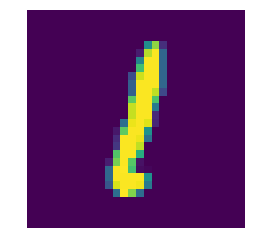

In [11]:
sess.run(y_pred, feed_dict={x: batch_x, y: batch_y})

array([[ 0.52937311],
       [ 0.54435617]], dtype=float32)

In [12]:
sess.run(w1, feed_dict={x: batch_x, y: batch_y})

array([[ 0.01,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01],
       [ 0.01,  0.01,  0.01,  0.01,  0.01]], dtype=float32)

In [13]:
print(Grad_w_fc)

[[  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [ -1.65059682e-04]
 [ -8.40754900e-03]
 [ -7.61201186e-03]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [ -2.22830698e-02]
 [ -1.26191512e-01]
 [ -1.14051312e-01]
 [ -9.63474903e-03]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [ -7.46387839e-02]
 [ -2.63962418e-01]
 [ -2.27320820e-01]
 [ -2.60252394e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [ -1.35029942e-01]
 [ -3.14611614e-01]
 [ -2.34189838e-01]
 [ -2.35926230e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]


In [14]:
print(compare_wfc)

[array([[  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [ -1.65059668e-04],
       [ -8.40754900e-03],
       [ -7.61201140e-03],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [ -2.22830698e-02],
       [ -1.26191512e-01],
       [ -1.14051312e-01],
       [ -9.63474903e-03],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [ -7.46387839e-02],
       [ -2.63962388e-01],
       [ -2.27320805e-01],
       [ -2.60252394e-02],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],
       [  0.00000000e+00],


In [15]:
print(Grad_w1)

[[-0.20380892 -0.27027059 -0.27701259 -0.27396226 -0.25527936]
 [-0.24177031 -0.29419428 -0.29442412 -0.29264945 -0.26741979]
 [-0.26012176 -0.29442412 -0.29442412 -0.29442412 -0.25897419]
 [-0.26416188 -0.29315376 -0.29442415 -0.29347599 -0.23489115]
 [-0.25489306 -0.27934352 -0.28198174 -0.27645618 -0.19596761]]


In [16]:
print(compare_w1)

[array([[-0.20380889, -0.27027059, -0.2770125 , -0.27396226, -0.25527936],
       [-0.24177031, -0.29419428, -0.29442412, -0.29264939, -0.26741976],
       [-0.26012173, -0.29442409, -0.29442409, -0.29442415, -0.25897416],
       [-0.26416188, -0.2931537 , -0.29442409, -0.29347599, -0.23489115],
       [-0.25489303, -0.27934352, -0.28198177, -0.27645618, -0.19596764]], dtype=float32)]


In [ ]:
print(Grad_b_fc)

In [ ]:
print(compare_bfc)

In [ ]:
print(Grad_w2)

In [ ]:
print(compare_w2)

In [ ]:
print(Grad_b1)

In [ ]:
print(compare_b1)

In [ ]:
print(Grad_b2)

In [ ]:
print(compare_b2)